# Aerial Image Preprocessing for multi temporal data for Iceland

For this preprocessing we will use only pseudofiducials markers, because all fiducials markers are erased

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import hipp
import pandas as pd
from pathlib import Path

In [ ]:
project_dir = Path("/mnt/summer/USERS/DEHECQA/history/data_prep/iceland/aerial_images/1980_07_28_aux")

paths: dict[str, Path] = {}
paths["raw_images"] = project_dir / "raw_images"
paths["preproc_images"] = project_dir / "preprocessed_images"
paths["crop_images"] = project_dir / "cropped_images"
paths["fiducial_templates"] = project_dir / "fiducial_templates"
paths["qc"] = project_dir / "qc"
paths["detected_fiducials"] = paths["raw_images"] / "detected_fiducial_markers.csv"
paths["detected_pseudo_fiducials"] = paths["raw_images"] / "detected_pseudo_fiducial_markers.csv"
paths["tf_detected_fiducials"] = paths["preproc_images"] / "detected_fiducial_markers.csv"
paths["crop_detected_fiducials"] = paths["crop_images"] / "detected_fiducial_markers.csv"
paths["intrinsics"] = project_dir / "camera_model_intrinsics.csv"
paths["extrinsics"] = project_dir / "camera_model_extrinsics.csv"
paths["footprint"] = project_dir / "images_footprint.geojson"
paths["dir"] = project_dir

project_dir.mkdir(parents=True, exist_ok=True)

MAX_WORKERS = 4
QUICKVIEW_FACTOR = 0.2
OVERWRITE = False

In [11]:
hipp.tools.generate_quickviews(paths["raw_images"], QUICKVIEW_FACTOR, max_workers=MAX_WORKERS, overwrite=OVERWRITE)

Generating quickviews: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:23<00:00,  1.09s/image]


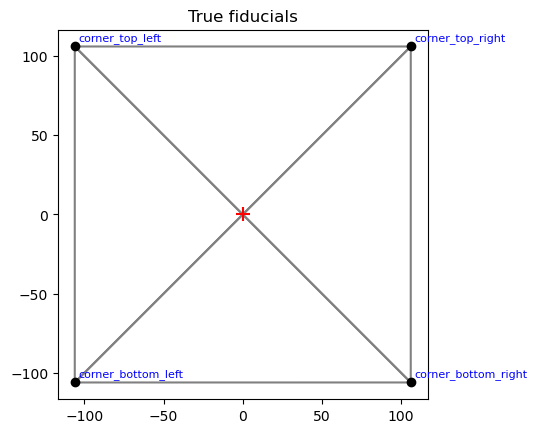

In [34]:
focal_length = 151.78
pixel_pitch = 0.02

fiducial_coords = [
    (-106.000, -106.004),
    (-106.001, 106.004),
    (106.003, 106.007),
    (105.993, -105.997),
    (0.003, 0.002) # ppa
]
intrinsics = hipp.Intrinsics.from_list(focal_length, pixel_pitch, fiducial_coords)
intrinsics.to_csv(paths["intrinsics"])
hipp.aerial.qc.plot_true_fiducials(intrinsics.true_fiducials_mm)

midside_left {'coordinate': (1084, 5948), 'center_coordinate': (27, 97)}
midside_top {'coordinate': (6791, 236), 'center_coordinate': (98, 16)}
midside_right {'coordinate': (12495, 5936), 'center_coordinate': (183, 100)}
midside_bottom {'coordinate': (6798, 11647), 'center_coordinate': (101, 173)}


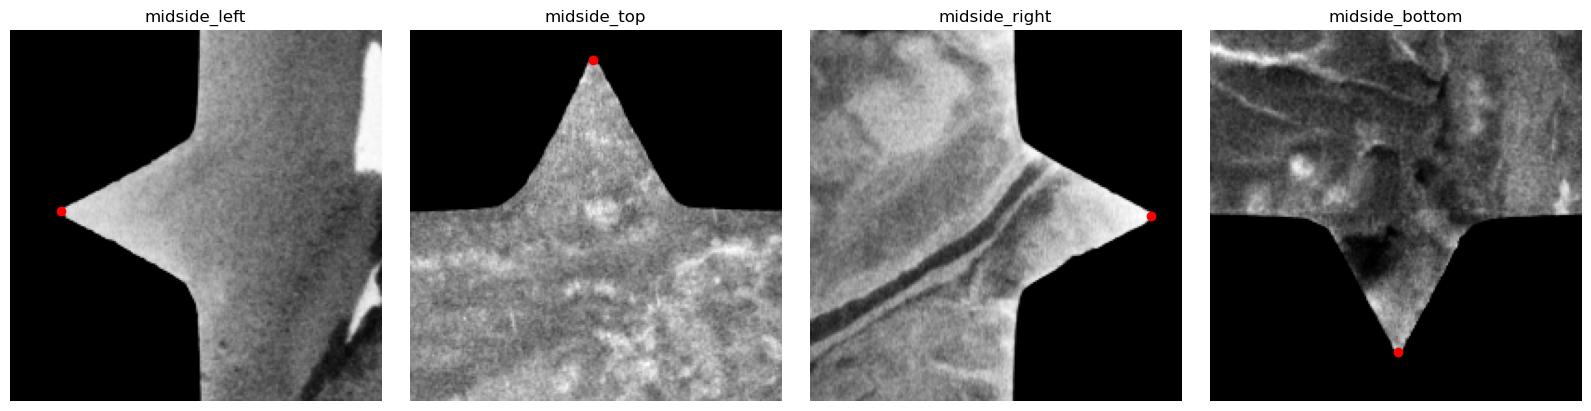

In [13]:
first_image_path = sorted(paths["raw_images"].glob("*.tif"))[0]
saved_coords = {
    "midside_left": {'coordinate': (1084, 5948), 'center_coordinate': (27, 97)},
    "midside_top": {'coordinate': (6791, 236), 'center_coordinate': (98, 16)},
    "midside_right": {'coordinate': (12495, 5936), 'center_coordinate': (183, 100)},
    "midside_bottom": {'coordinate': (6798, 11647), 'center_coordinate': (101, 173)},

}
for side, coords in saved_coords.items():
    tmp_coords = hipp.aerial.create_pseudo_fiducial_templates(first_image_path, paths["fiducial_templates"], side, **coords) 
    print(side, tmp_coords)

hipp.aerial.qc.plot_pseudo_fiducial_templates(paths["fiducial_templates"])

Fiducial detections: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:32<00:00,  2.40Image/s]


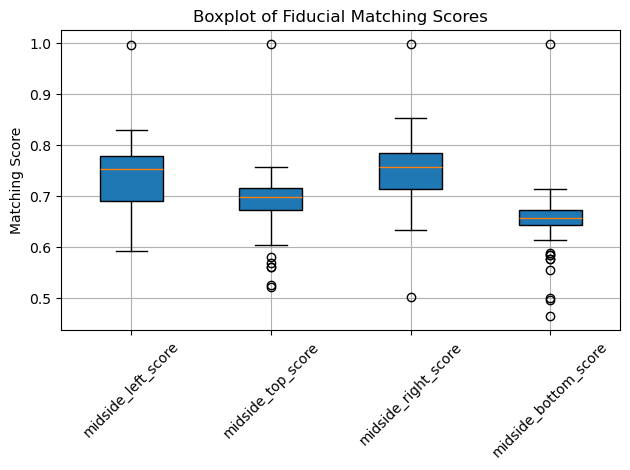

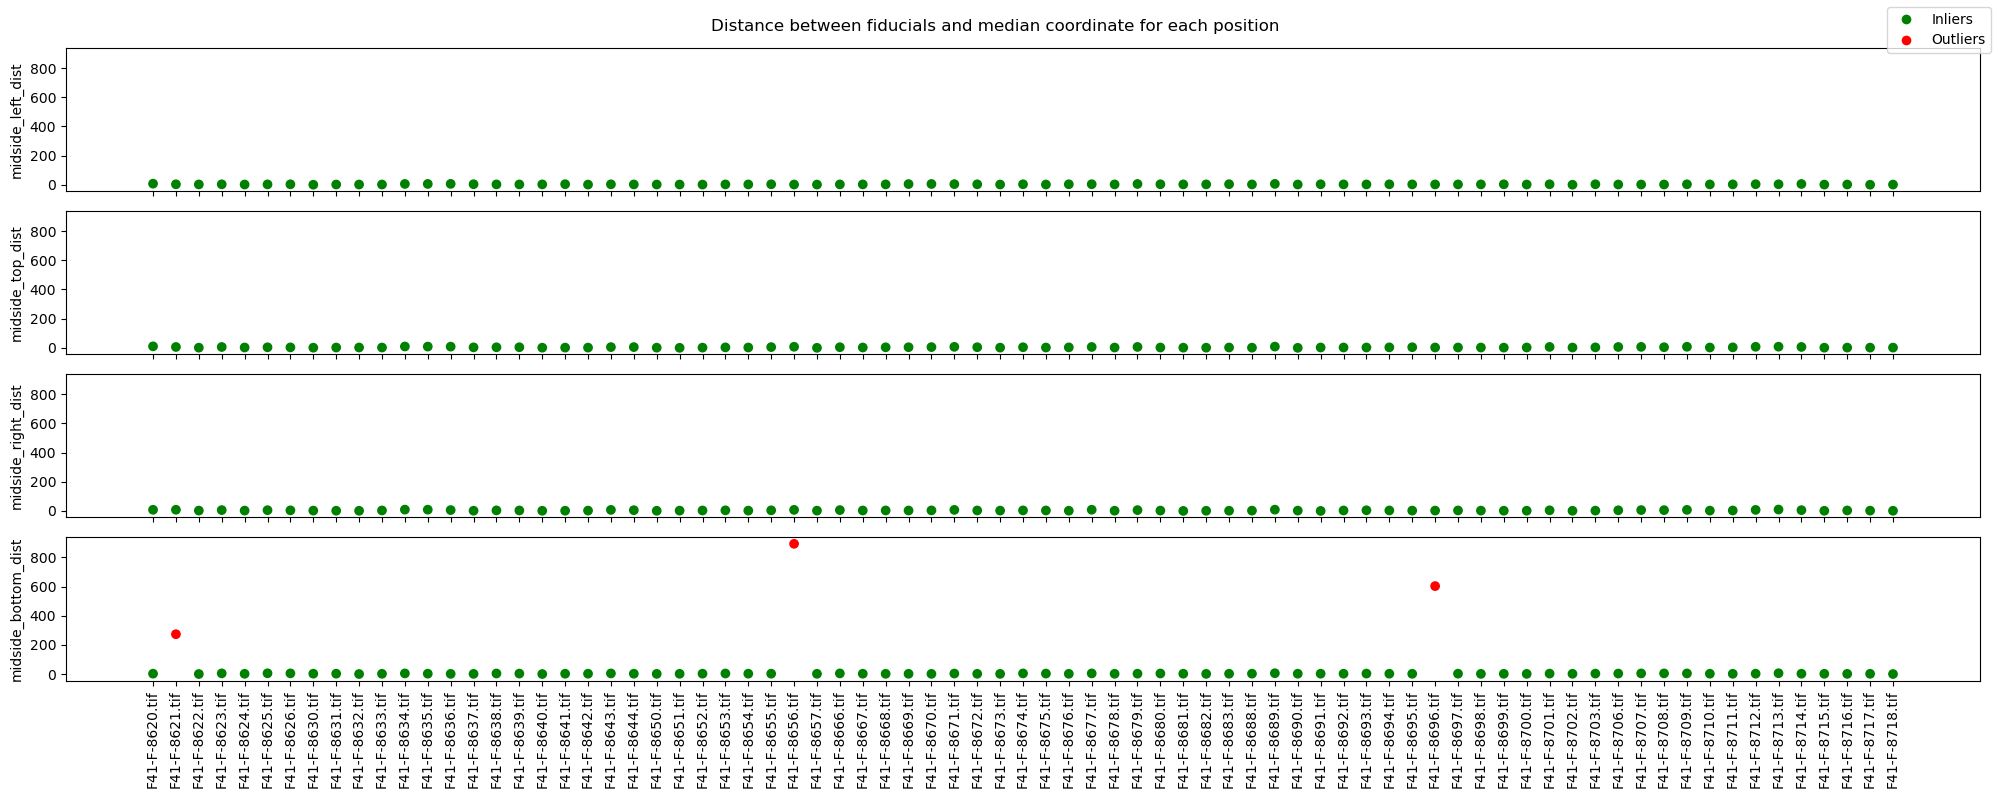

In [30]:

detected_fiducials_df = hipp.aerial.iter_detect_pseudo_fiducials(paths["raw_images"], paths["fiducial_templates"], grid_size=7, max_workers=MAX_WORKERS)

# filter detection and save them into a csv
filtered_detected_fiducials_df = hipp.aerial.filter_detected_fiducials(detected_fiducials_df)
filtered_detected_fiducials_df.round(2).to_csv(paths["detected_pseudo_fiducials"])

# plot matching score
output_plot_path = paths["qc"] / "pseudo_detection_score_boxplot.png"
hipp.aerial.qc.plot_detection_score_boxplot(detected_fiducials_df, show=True, output_plot_path=output_plot_path)

# plot fiducials filtering
output_plot_path = paths["qc"] / "pseudo_fiducials_filtering.png"
hipp.aerial.qc.plot_fiducials_filtering(detected_fiducials_df,filtered_detected_fiducials_df, show=True, output_plot_path=output_plot_path)

# plot individuals detection
output_dir = paths["qc"] / "individual_pseudo_detections"
hipp.aerial.qc.generate_detection_qc_plots(paths["raw_images"], detected_fiducials_df, output_dir)


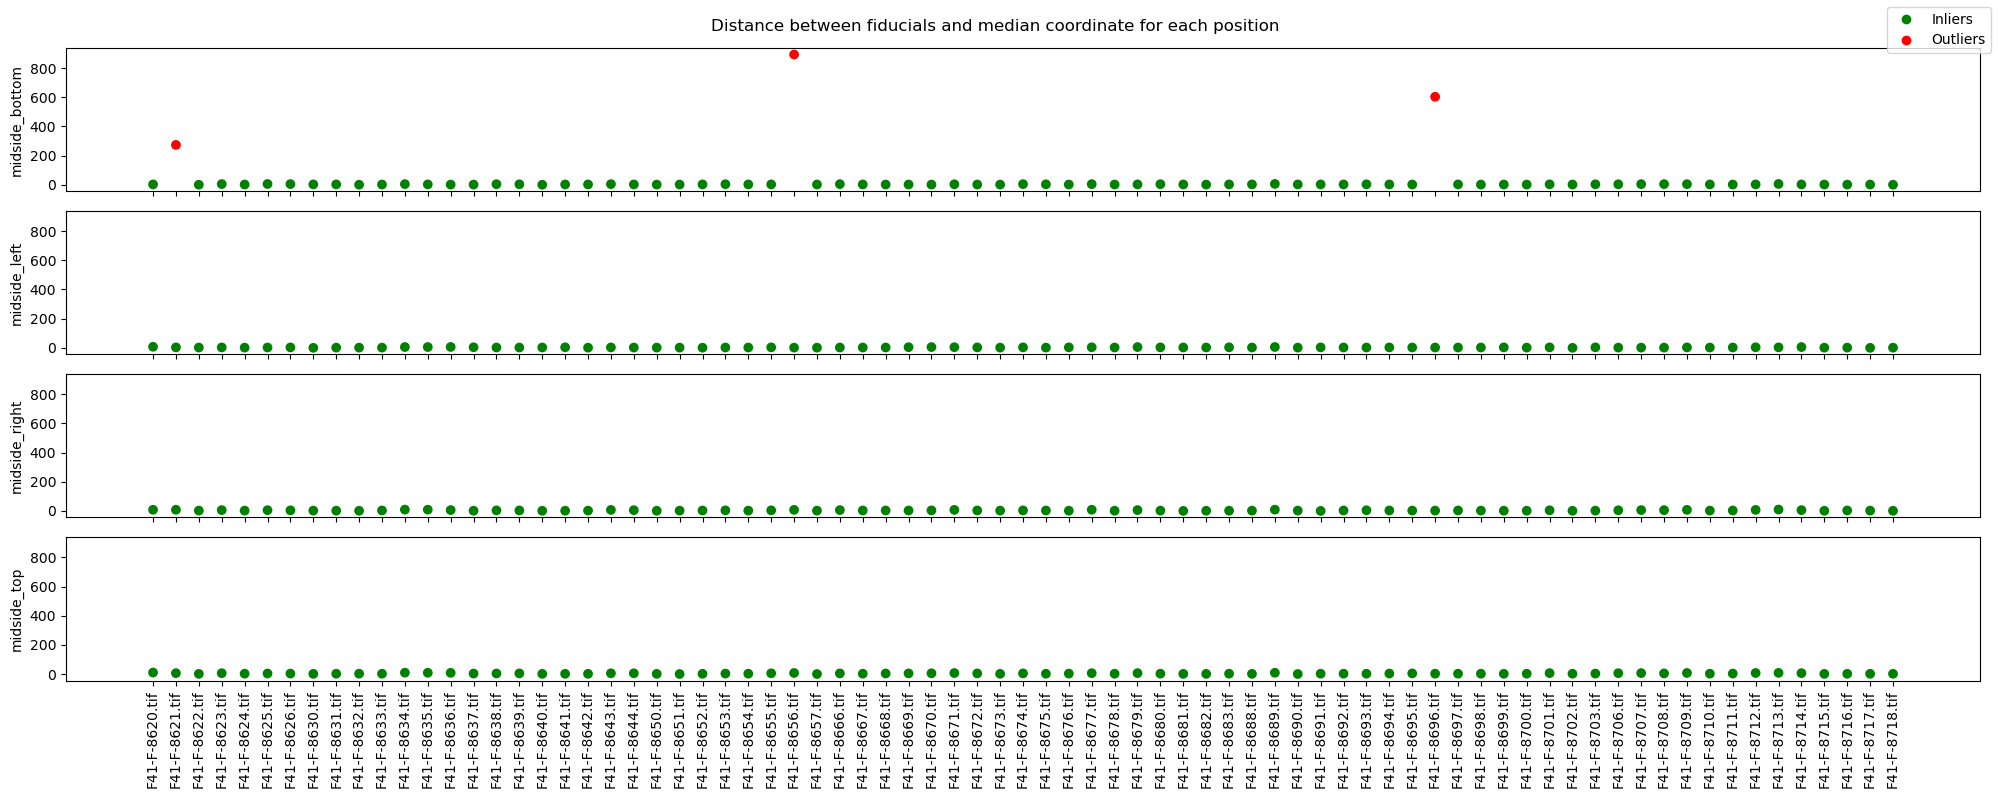

In [48]:
hipp.aerial.qc.plot_fiducials_filtering(detected_fiducials_df,filtered_detected_fiducials_df, show=True, output_plot_path=output_plot_path)

In [36]:
intrinsics = hipp.Intrinsics.from_csv(paths["intrinsics"])
image_square_dim = int(228.6 / intrinsics.pixel_pitch) - 5 

pseudo_fiducials_df = pd.read_csv(paths["detected_pseudo_fiducials"], index_col="image_id")

transformations = hipp.aerial.compute_transformations(pseudo_fiducials_df, None, image_square_dim, intrinsics.pixel_pitch)

hipp.aerial.iter_image_restitution(
    paths["raw_images"], 
    paths["preproc_images"], 
    transformations,
    image_square_dim=image_square_dim,
    max_workers=MAX_WORKERS,
    overwrite=OVERWRITE
)
hipp.tools.generate_quickviews(paths["preproc_images"], factor=QUICKVIEW_FACTOR, max_workers=MAX_WORKERS, overwrite=OVERWRITE)

Generating quickviews: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:51<00:00,  1.51image/s]


In [45]:
import numpy as np
df_xy = detected_fiducials_df.filter(regex=r"(_x|_y)$")
median_series = df_xy.median()

df_xy.T.groupby(df_xy.columns.str.rsplit("_", n=1).str[0]).agg(lambda row: np.linalg.norm(np.array(row) - np.array(median_series[row.index]))).T

,midside_bottom,midside_left,midside_right,midside_top
image_id,,,,
F41-F-8620.tif,2.236068,7.280110,7.810250,10.198039
F41-F-8621.tif,273.001831,3.000000,8.000000,5.830952
F41-F-8622.tif,0.000000,2.000000,2.236068,1.000000
F41-F-8623.tif,4.472136,2.828427,5.656854,5.656854
F41-F-8624.tif,1.414214,1.414214,2.236068,2.236068
...,...,...,...,...
F41-F-8714.tif,2.000000,5.099020,5.385165,6.000000
F41-F-8715.tif,1.414214,1.000000,1.000000,1.000000
F41-F-8716.tif,1.000000,1.414214,3.162278,1.414214


In [47]:
df_xy.columns.str.rsplit("_", n=1).str[0].unique()

Index(['midside_left', 'midside_top', 'midside_right', 'midside_bottom'], dtype='object')